## **VGG** **MODEL**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset_path = '/content/drive/My Drive/Human Action Recognition'

In [8]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Paths to your data and CSV files
dataset_path = '/content/drive/My Drive/HAR/Human Action Recognition'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
train_labels_path = os.path.join(dataset_path, 'Training_set.csv')
test_labels_path = os.path.join(dataset_path, 'Testing_set.csv')  # Assuming you have a separate CSV for test labels

# Load the labels from the CSV files into DataFrames
train_labels_df = pd.read_csv(train_labels_path)
test_labels_df = pd.read_csv(test_labels_path)  # If you have test labels

# Split the data into training and validation sets
train_df, valid_df = train_test_split(train_labels_df, test_size=0.3, random_state=42, stratify=train_labels_df['label'])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators with normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Generators for training and validation data using the dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_path,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Consistent ordering for validation
)

# ImageDataGenerator for test data, rescaling only
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for test data using the dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # Dataframe containing test filenames only
    directory=test_path,
    x_col='filename',
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # Since we don't have labels
    shuffle=False  # Keep data in same order as dataframe for evaluation
)

Found 8820 validated image filenames belonging to 15 classes.
Found 3780 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

vgg_model = Sequential()

# Load the pre-trained VGG16 model without the top classification layer
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(64, 64, 3),
    pooling='avg',  # Applies global average pooling to the output of the last conv layer
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model as the base
vgg_model.add(pretrained_model)

# Add new classification layers
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))  # 15 classes for your dataset

# Print the model summary
vgg_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14985039 (57.16 MB)
Trainable params: 270351 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_path = "vgg_model_weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',  # You can monitor 'val_accuracy' as well if you prefer
    verbose=1,
    save_best_only=True,  # Set to False if you want to save after every epoch regardless of performance
    save_weights_only=True,  # If you want to save the entire model, set this to False
    mode='min',  # 'min' because we want to minimize val_loss; use 'max' for 'val_accuracy'
    save_freq='epoch'  # Save after every epoch
)

# Compile the model
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Fit the model with the checkpoint callback
history = vgg_model.fit(
    train_generator,
    epochs=25,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback here
)

Epoch 1/25
276/276 [==============================] - ETA: 0s - loss: 2.3298 - accuracy: 0.2421
Epoch 1: val_loss improved from inf to 2.11728, saving model to vgg_model_weights.h5
276/276 [==============================] - 2454s 9s/step - loss: 2.3298 - accuracy: 0.2421 - val_loss: 2.1173 - val_accuracy: 0.3032
Epoch 2/25
276/276 [==============================] - ETA: 0s - loss: 2.1371 - accuracy: 0.3015
Epoch 2: val_loss improved from 2.11728 to 2.05487, saving model to vgg_model_weights.h5
276/276 [==============================] - 41s 147ms/step - loss: 2.1371 - accuracy: 0.3015 - val_loss: 2.0549 - val_accuracy: 0.3246
Epoch 3/25
276/276 [==============================] - ETA: 0s - loss: 2.0762 - accuracy: 0.3188
Epoch 3: val_loss did not improve from 2.05487
276/276 [==============================] - 41s 148ms/step - loss: 2.0762 - accuracy: 0.3188 - val_loss: 2.0688 - val_accuracy: 0.3312
Epoch 4/25
276/276 [==============================] - ETA: 0s - loss: 2.0296 - accuracy: 0

In [ ]:
As we can see the best accuracy we got is of 43% after 25 epochs, so we train on test data on this

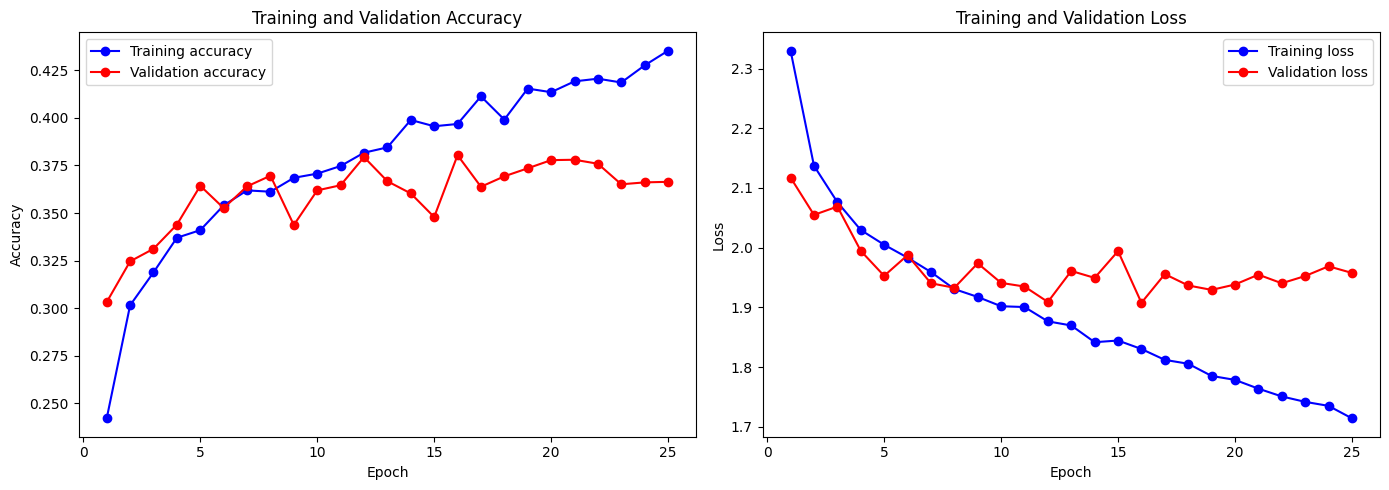

In [2]:
import matplotlib.pyplot as plt

# Manually extracted values from the provided training output
accuracy = [0.2421, 0.3015, 0.3188, 0.3370, 0.3410, 0.3540, 0.3619, 0.3612, 0.3685, 0.3707, 0.3747, 0.3817, 0.3845, 0.3989, 0.3956, 0.3968, 0.4113, 0.3991, 0.4154, 0.4135, 0.4192, 0.4206, 0.4186, 0.4276, 0.4353]
val_accuracy = [0.3032, 0.3246, 0.3312, 0.3439, 0.3643, 0.3526, 0.3640, 0.3696, 0.3437, 0.3619, 0.3646, 0.3794, 0.3667, 0.3603, 0.3479, 0.3804, 0.3638, 0.3693, 0.3735, 0.3778, 0.3780, 0.3759, 0.3651, 0.3661, 0.3664]
loss = [2.3298, 2.1371, 2.0762, 2.0296, 2.0049, 1.9833, 1.9592, 1.9307, 1.9175, 1.9019, 1.9006, 1.8766, 1.8697, 1.8417, 1.8445, 1.8303, 1.8121, 1.8056, 1.7852, 1.7786, 1.7639, 1.7509, 1.7418, 1.7351, 1.7142]
val_loss = [2.1173, 2.0549, 2.0688, 1.9947, 1.9528, 1.9874, 1.9404, 1.9328, 1.9738, 1.9410, 1.9349, 1.9091, 1.9610, 1.9494, 1.9942, 1.9077, 1.9557, 1.9367, 1.9293, 1.9383, 1.9548, 1.9404, 1.9525, 1.9688, 1.9577]

epochs = range(1, 26)  # 25 epochs

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing**

In [1]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

def preprocess_image(image_path, target_size=(64, 64)):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels by 1/255 (model was trained on this scale)
    img_array = img_array / 255.0
    # Add an extra dimension for batch size
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [10]:
import os

# Assuming test_path is the path to the folder containing your test images
test_image_paths = [os.path.join(test_path, img) for img in os.listdir(test_path) if img.endswith(".jpg")]

# Check the number of image paths collected
print(f"Collected {len(test_image_paths)} image paths.")

Collected 5417 image paths.


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

def preprocess_image(image_path, target_size=(64, 64)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Assuming vgg_model is your trained model
def predict_on_test_set(model, image_paths):
    predictions = []
    for img_path in image_paths:
        # Preprocess the image
        img_array = preprocess_image(img_path)
        # Get model predictions
        pred = model.predict(img_array)
        # Get the index of the highest probability class
        predicted_class = np.argmax(pred, axis=1)[0]
        predictions.append(predicted_class)
    return predictions

# Get predictions
test_predictions = predict_on_test_set(vgg_model, test_image_paths)

# Create a DataFrame to store paths and predictions
predictions_df = pd.DataFrame({
    'image_path': test_image_paths,
    'predicted_class': test_predictions
})

# Save to CSV
predictions_df.to_csv('/content/drive/My Drive/HAR/Human Action Recognition/test_predictions.csv', index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step


In [16]:
print(predictions_df)

                                             image_path  predicted_class
0     /content/drive/My Drive/HAR/Human Action Recog...               13
1     /content/drive/My Drive/HAR/Human Action Recog...                8
2     /content/drive/My Drive/HAR/Human Action Recog...                8
3     /content/drive/My Drive/HAR/Human Action Recog...               13
4     /content/drive/My Drive/HAR/Human Action Recog...               13
...                                                 ...              ...
5412  /content/drive/My Drive/HAR/Human Action Recog...               13
5413  /content/drive/My Drive/HAR/Human Action Recog...                8
5414  /content/drive/My Drive/HAR/Human Action Recog...                8
5415  /content/drive/My Drive/HAR/Human Action Recog...               13
5416  /content/drive/My Drive/HAR/Human Action Recog...                8

[5417 rows x 2 columns]


## So we were able to predict for the test labels as shown above but as true labels of dataset not available so we cannot check for its accuracy.